<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [1]:
!wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw3/requirements.txt

--2023-05-17 21:16:13--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw3/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      77  --.-KB/s    in 0s      

2023-05-17 21:16:13 (5.62 MB/s) - ‘requirements.txt’ saved [77/77]



In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.2/273.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━

In [3]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy

warnings.filterwarnings('ignore')

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [4]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 21.5MB/s]                   


Взглянем на то, что представляют из себя данные:

In [5]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [6]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

In [7]:
df.describe()

CashIn        CashOut        target
count    1081.000000    1094.000000   1072.000000
mean    37261.618871  -30985.648995   5976.651119
std     20583.186636   18314.048275  21551.659802
min       100.000000 -111700.000000 -75190.000000
25%     21690.000000  -40375.000000  -6277.500000
50%     34980.000000  -27895.000000   5320.000000
75%     50280.000000  -18010.000000  18515.000000
max    121300.000000      -0.000000  85160.000000

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

In [8]:
import matplotlib.pyplot as plt
from datetime import datetime

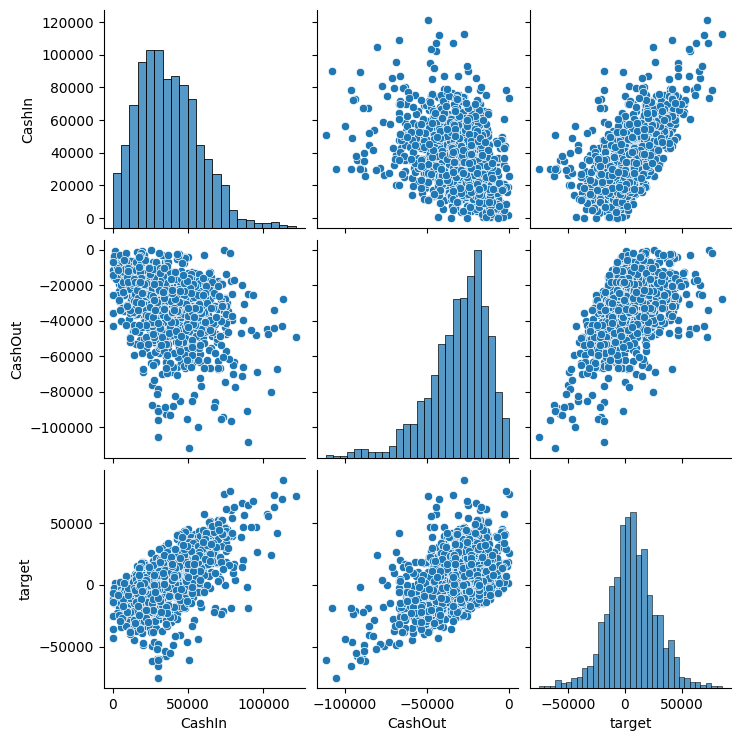

In [9]:
sns.pairplot(df)

<Axes: >

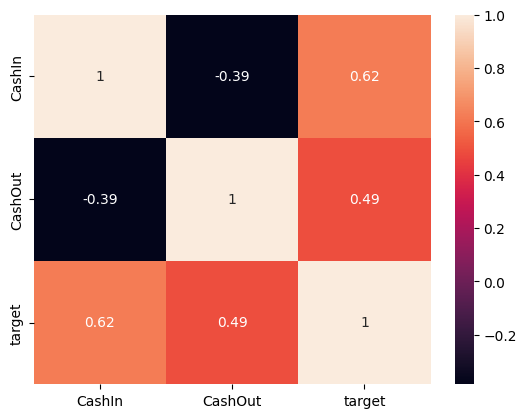

In [10]:
sns.heatmap(df.corr("pearson"), annot=True)

По этим двум графикам видна большая положительная корреляция `CashIn` с `target` и, чуть меньшая, `CashOut` с `target` (что логично, так как значение `target` мы получили из значений `CashIn` и `CashOut`).

In [11]:
df_time = deepcopy(df)

In [12]:
df_time['Weekday'] = df_time.Date.map(lambda x: datetime(int(x.split('/')[2]), int(x.split('/')[0]), int(x.split('/')[1])).strftime('%A'))
df_time['Month'] = df_time.Date.map(lambda x: int(x.split('/')[0]))

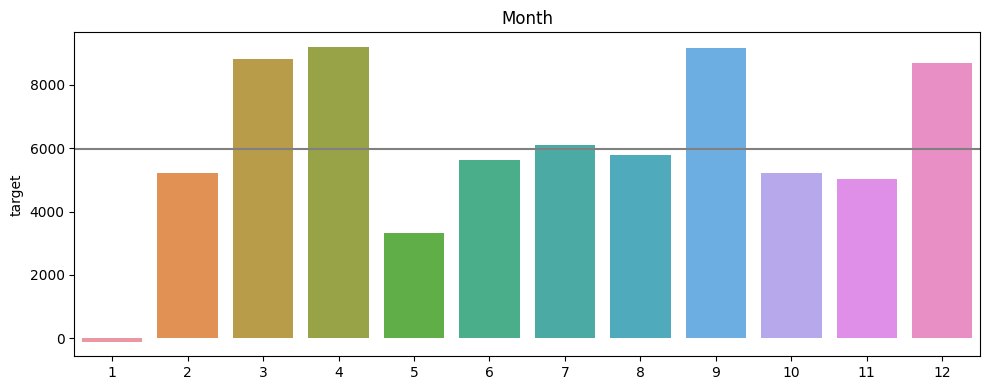

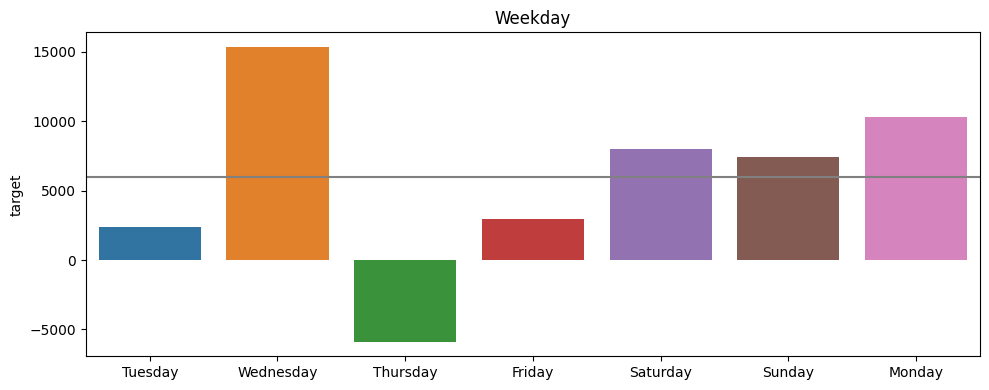

In [13]:
times = ['Month','Weekday']
for col in times:
    plt.figure(figsize=(10,4))
    graph = sns.barplot(df_time[col].value_counts().index, df_time.groupby([col])['target'].mean())
    graph.axhline(df_time.describe()['target']['mean'], c='grey')
    plt.title(col)
    plt.tight_layout()

Если смотреть на месяца, то видно, что весной (в марте и апреле) `target` сильно больше среднего (то есть внесено денег больше, чем снято). В мае же он смильно меньше среднего, чтобы, видимо, бороться с переизбытком после первых двух весенних месяцев. Также выделяются сентябрь и декабрь (возможно, в связи с началом рабоче-учебного сезона и приближающимися новогодними праздниками соответственно). 

Также сильно больше среднего вносят в среды и понедельники. При этом в четверги `target` "уходит в минус", но это нормально, так как остается избыток после вторника.



### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [14]:
from etna.datasets.tsdataset import TSDataset

In [15]:
df_ts = deepcopy(df)
df_ts = df_ts.reset_index(drop=True)
df_ts = df_ts.rename(columns={'Date': 'timestamp'})
df_ts['timestamp'] = df_ts.timestamp.map(lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y-%m-%d'))
df_ts = pd.melt(df_ts, id_vars=['timestamp'], value_vars=['CashIn', 'CashOut', 'target'], var_name='segment', value_name='target')

In [16]:
df_ts = TSDataset.to_dataset(df_ts)
ts = TSDataset(df=df_ts, freq='D')

In [17]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
CashIn        2016-01-05    2019-03-31    1182          101             3   
CashOut       2016-01-05    2019-03-31    1182           88             3   
target        2016-01-05    2019-03-31    1182          110             3   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
CashIn            0               0                 0    D  
CashOut           0               0                 0    D  
target            0               0                 0    D

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

Я выбрала `TimeSeriesImputerTransform` для заполнения пропущенных данных, так как это специальный метод разработанный под эти нужды, в котором, в частности, можно указывать "сезонную стратегию" заполнения `NaN`, что полезно, так как мы видели, что весной `target` выше среднего.

In [18]:
from etna.analysis import get_anomalies_density, plot_anomalies
from etna.transforms import TimeSeriesImputerTransform, DensityOutliersTransform

In [19]:
ts.describe().num_missing

segments
CashIn     101
CashOut     88
target     110
Name: num_missing, dtype: int64

In [20]:
ts_fillna = deepcopy(ts)

In [21]:
transformer_nan = [
    TimeSeriesImputerTransform(in_column='target', strategy='seasonal', seasonality=3),
]

In [22]:
ts_fillna.fit_transform(transformer_nan)

In [23]:
ts_fillna.describe().num_missing

segments
CashIn     0
CashOut    0
target     0
Name: num_missing, dtype: int64

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

Для того, чтобы убрать аутлаеры, я использовала `DensityOutliersTransform`, так как, опять же, этот метод специально создан для их очистки и позволяет выделять на графике пики, которые сильно отличаются от остальных данных.

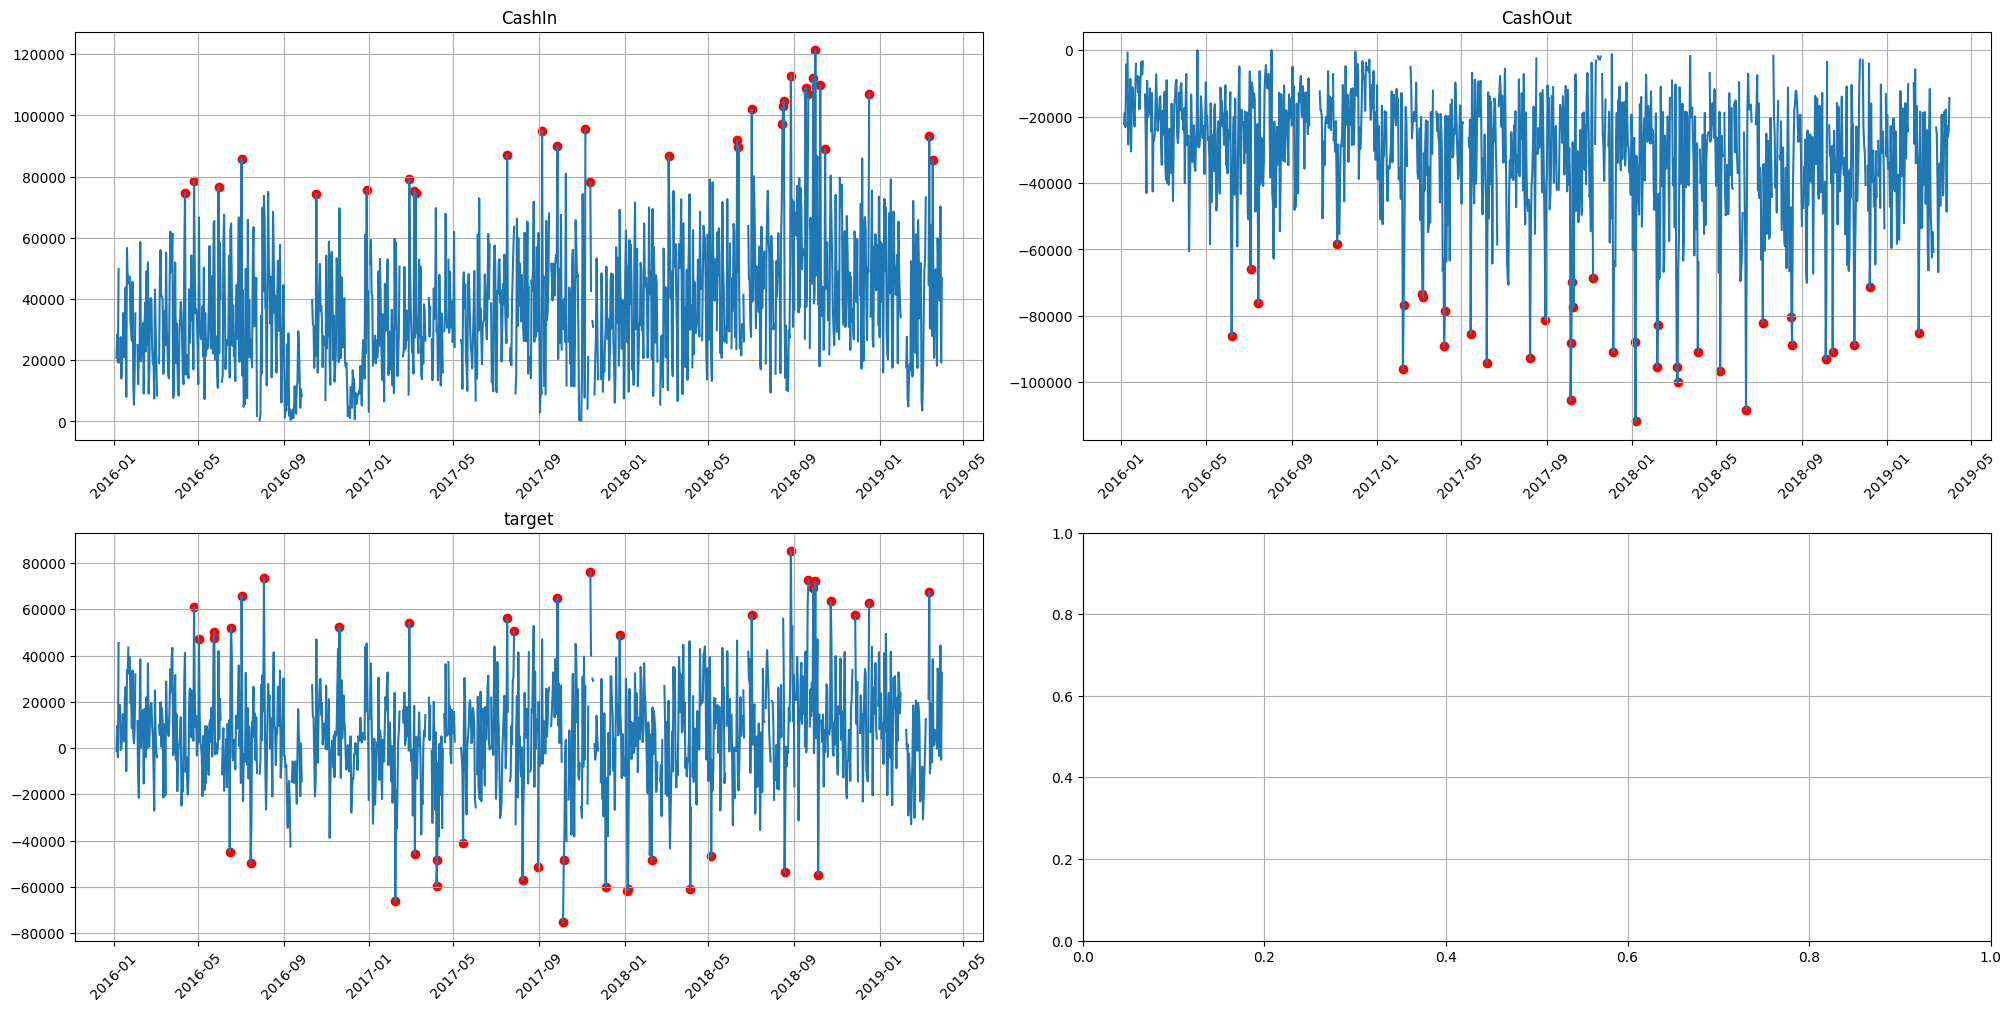

In [40]:
anomalies = get_anomalies_density(
    ts=ts, 
    window_size=40, 
    n_neighbors=20, 
    distance_coef=1.9
)
plot_anomalies(ts=ts, anomaly_dict=anomalies)

In [41]:
ts_fillna_out = deepcopy(ts)

In [42]:
transformers_out = [
    DensityOutliersTransform(in_column='target', window_size=40,  n_neighbors=20, distance_coef=1.5),
    TimeSeriesImputerTransform(in_column='target', strategy='seasonal', seasonality=3),
]

In [43]:
ts_fillna_out.fit_transform(transformers_out)

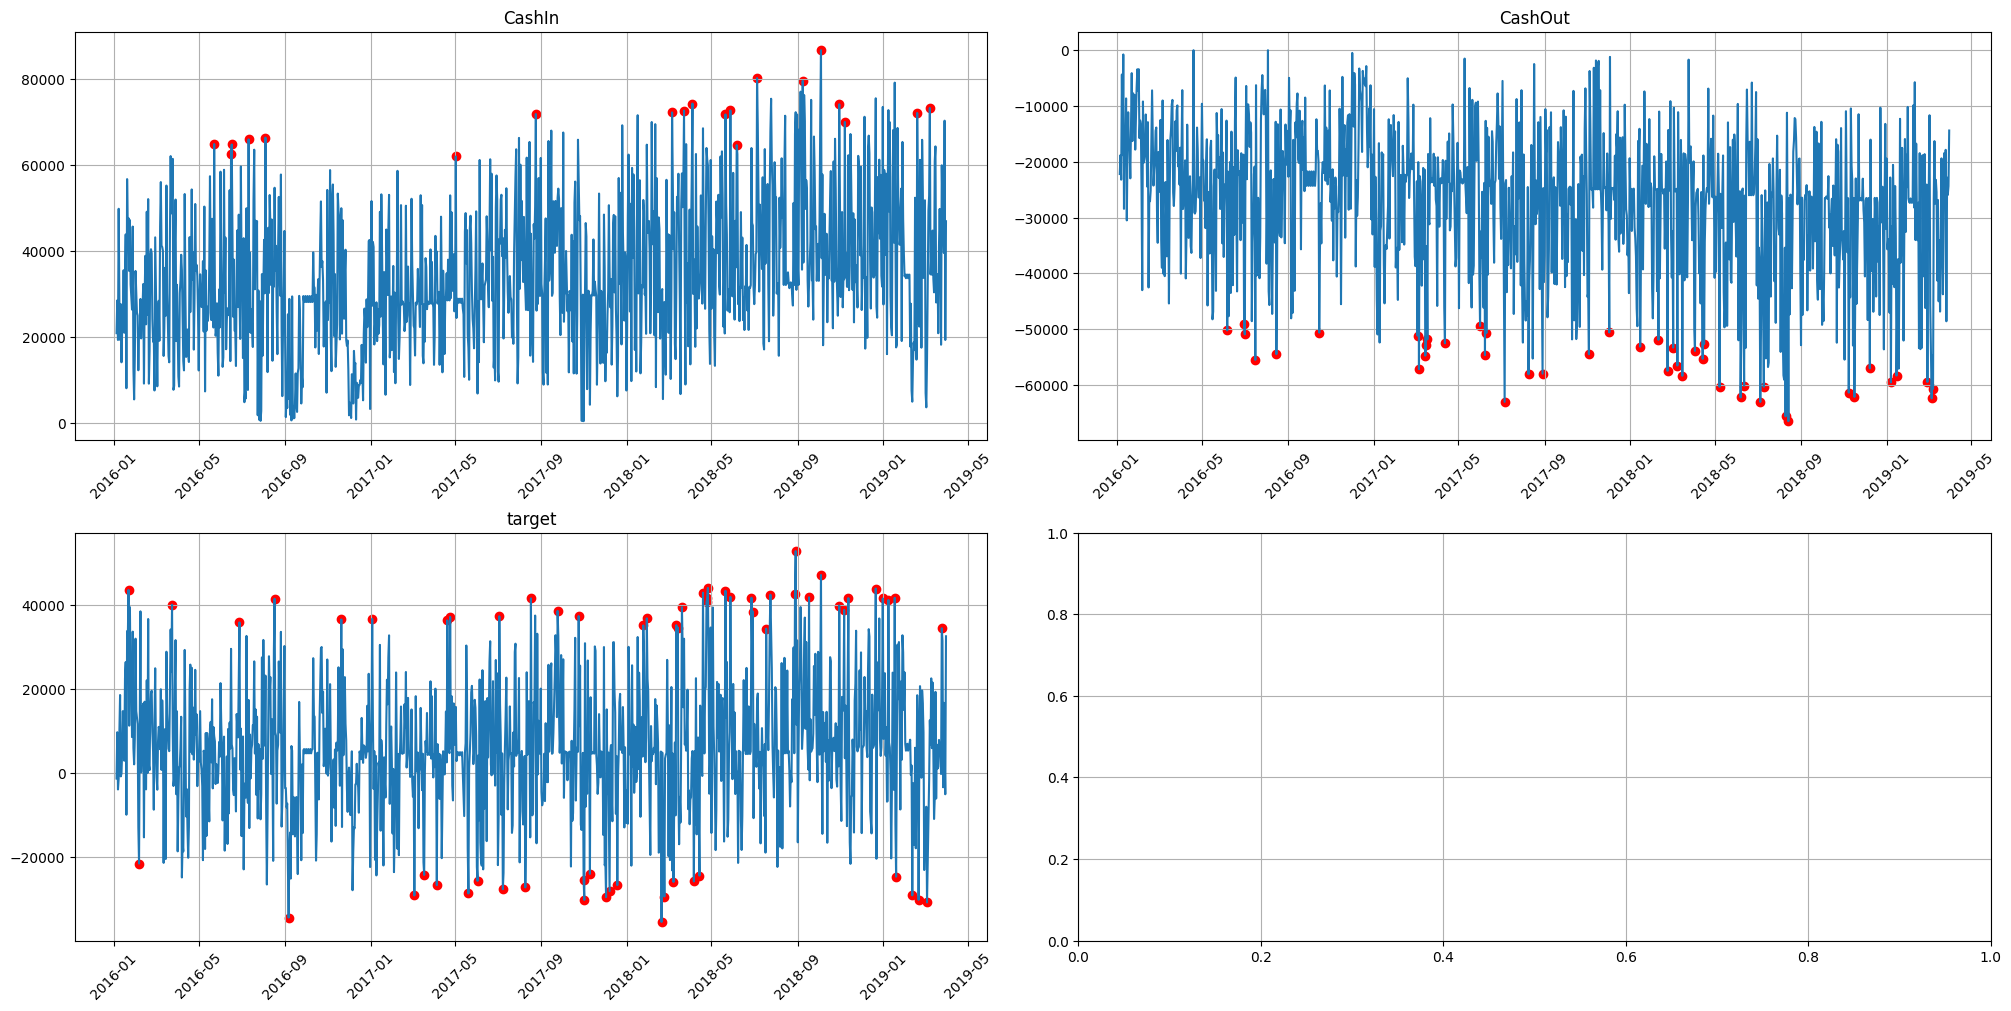

In [44]:
anomalies_out = get_anomalies_density(
    ts=ts_fillna_out, 
    window_size=40, 
    n_neighbors=20, 
    distance_coef=1.9
)
plot_anomalies(ts=ts_fillna_out, anomaly_dict=anomalies_out)

In [45]:
ts_fillna_out.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
CashIn        2016-01-05    2019-03-31    1182            0             3   
CashOut       2016-01-05    2019-03-31    1182            0             3   
target        2016-01-05    2019-03-31    1182            0             3   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
CashIn            0               0                 0    D  
CashOut           0               0                 0    D  
target            0               0                 0    D

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [31]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [32]:
HORIZON = 5

In [33]:
model = ProphetModel()
transforms = []


pipeline = Pipeline(
    model=model,
    transforms=transforms,
    horizon=HORIZON
)

In [34]:
METRICS_SMAPE = [SMAPE()]

metrics_smape, forecasts_smape, info_smape = pipeline.backtest(
    ts=ts_fillna_out,
    metrics=METRICS_SMAPE
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd98n9crr/6jwuy_8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd98n9crr/v4oallag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95779', 'data', 'file=/tmp/tmpd98n9crr/6jwuy_8v.json', 'init=/tmp/tmpd98n9crr/v4oallag.json', 'output', 'file=/tmp/tmpksar0mvs/prophet_model-20230517212456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:24:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:24:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

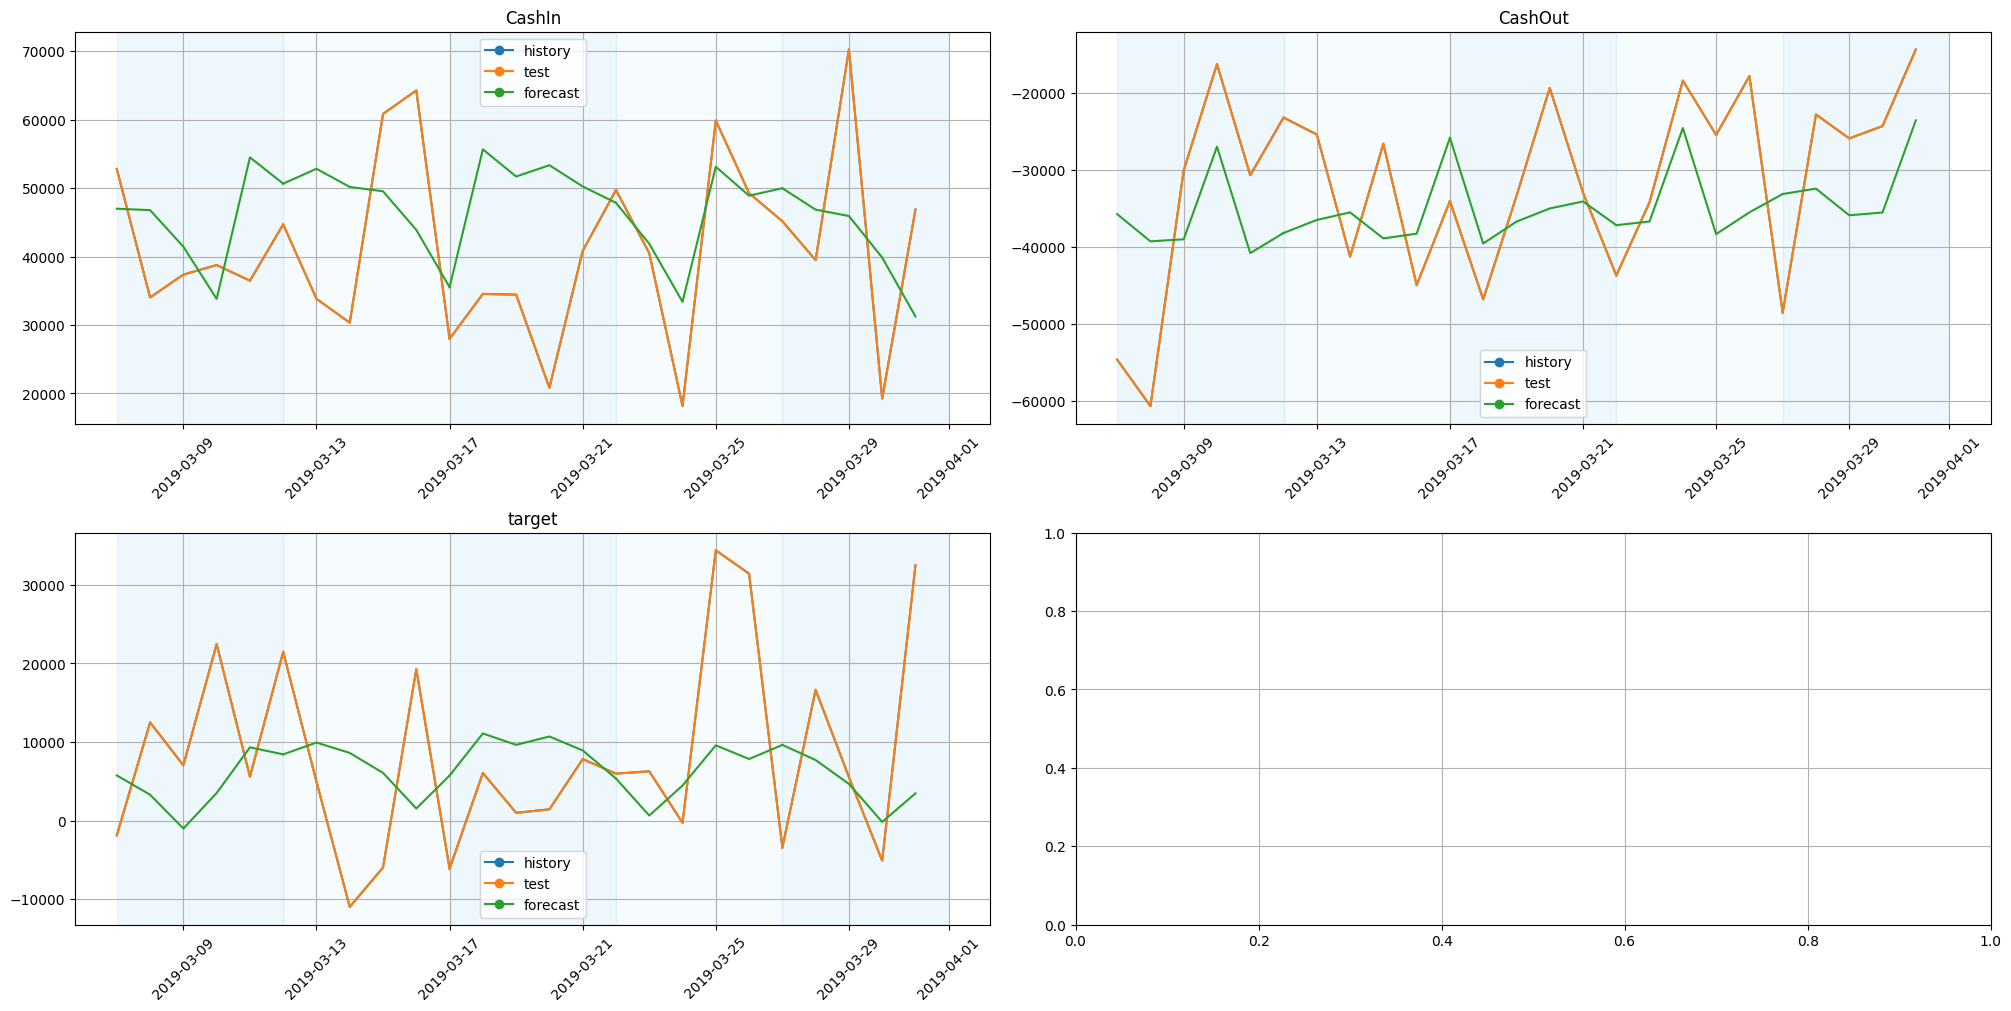

In [35]:
plot_backtest(forecast_df=forecasts_smape, ts=ts_fillna_out)

In [36]:
metrics_smape.head()

segment      SMAPE  fold_number
0  CashIn  21.374796            0
0  CashIn  32.766864            1
0  CashIn  43.828574            2
0  CashIn  15.801358            3
0  CashIn  35.763301            4

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

Лучше всего итоговое значение предсказывается по ряду `CashOut`, что было, на самом деле, видно еще на первых графиках, так как он больше всего коррелировал с `target`.

In [37]:
METRICS_MAE = [MAE()]

metrics_mae, forecasts_mae, info_mae = pipeline.backtest(
    ts=ts_fillna_out,
    metrics=METRICS_MAE
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd98n9crr/gzd8tk8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd98n9crr/_7_tx6a3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84089', 'data', 'file=/tmp/tmpd98n9crr/gzd8tk8c.json', 'init=/tmp/tmpd98n9crr/_7_tx6a3.json', 'output', 'file=/tmp/tmp8b2d4idz/prophet_model-20230517212552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:25:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

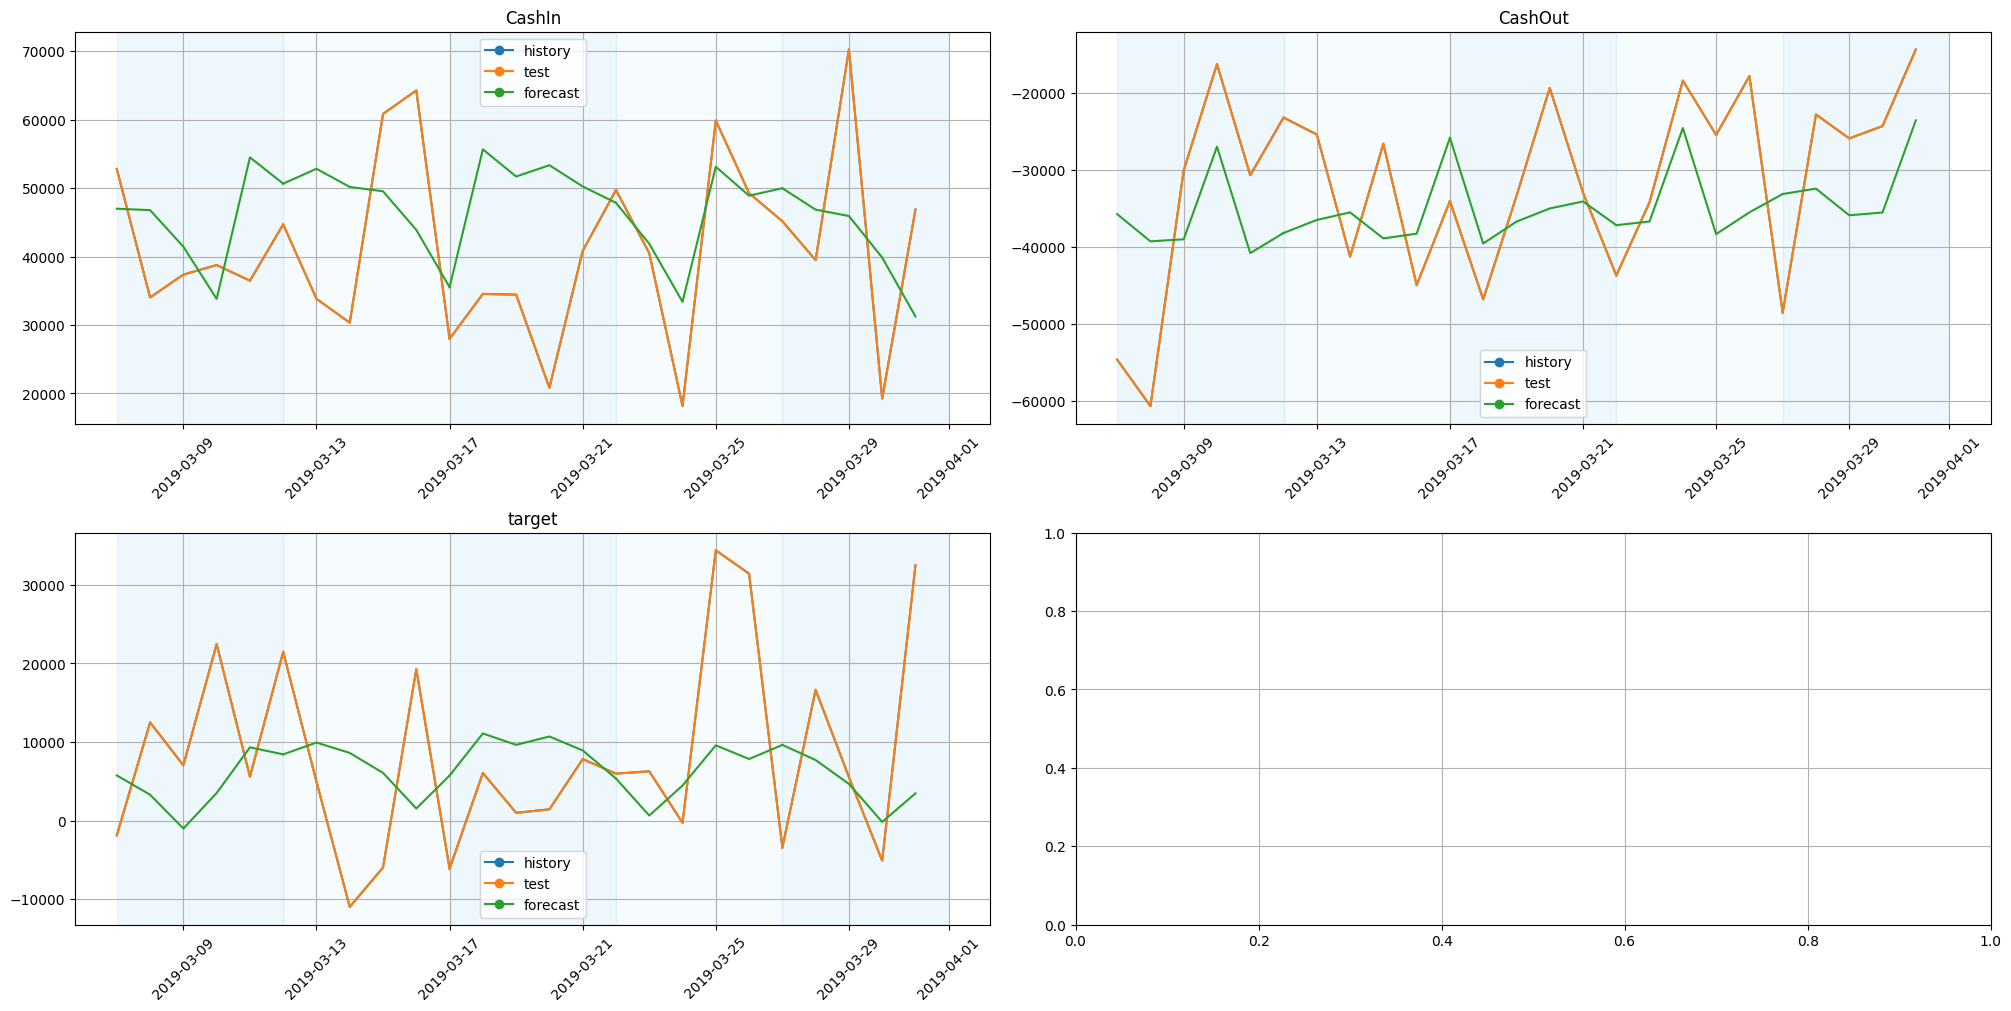

In [38]:
plot_backtest(forecast_df=forecasts_mae, ts=ts_fillna_out)

In [39]:
metrics_mae.head()

segment           MAE  fold_number
0  CashIn   9126.402773            0
0  CashIn  15299.595692            1
0  CashIn  17579.968495            2
0  CashIn   5121.625026            3
0  CashIn  14550.381457            4

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [39]:
from etna.datasets.hierarchical_structure import HierarchicalStructure
from etna.pipeline.hierarchical_pipeline import HierarchicalPipeline
from etna.reconciliation.bottom_up import BottomUpReconciliator

In [40]:
df_ts_hier = deepcopy(df)

In [41]:
df_ts_hier = df_ts_hier.rename(columns={'Date': 'timestamp'})
df_ts_hier['timestamp'] = df_ts_hier.timestamp.map(lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y-%m-%d'))
df_ts_hier = df_ts_hier.set_index('timestamp', drop=True)

In [42]:
segments = df_ts_hier.columns[:-1]
periods = len(df_ts_hier)

In [43]:
hierarchical_df = []
for segment_name in segments:
    segment = df_ts_hier[segment_name]

    segment_slice = pd.DataFrame(
        {'timestamp': segment.index, 'target': segment.values, 'segment': [segment_name] * periods}
    )
    hierarchical_df.append(segment_slice)
hierarchical_df = pd.concat(hierarchical_df, axis=0)

In [44]:
hierarchical_df = TSDataset.to_dataset(df=hierarchical_df)

In [45]:
hierarchical_structure = HierarchicalStructure(
    level_structure={'total': list(segments)}, level_names=['total', 'money_transfer']
)

In [46]:
hierarchical_ts = TSDataset(df=hierarchical_df, freq='D', hierarchical_structure=hierarchical_structure)

In [47]:
reconciliator = BottomUpReconciliator(target_level='total', source_level='money_transfer')

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [48]:
transformers = [
    DensityOutliersTransform(in_column='target', window_size=40,  n_neighbors=20, distance_coef=1.5),
    TimeSeriesImputerTransform(in_column='target', strategy='seasonal', seasonality=3),
]

In [49]:
pipeline = HierarchicalPipeline(
    transforms=transformers,
    model=model,
    reconciliator=reconciliator
)

bottom_up_metrics, bottom_up_forecasts, _ = pipeline.backtest(
    ts=hierarchical_ts, 
    metrics=[MAE()]
    )
bottom_up_metrics = bottom_up_metrics.set_index('segment').add_suffix('_bottom_up')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpswht6e3m/eei_7g4z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpswht6e3m/fs0acmf_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78179', 'data', 'file=/tmp/tmpswht6e3m/eei_7g4z.json', 'init=/tmp/tmpswht6e3m/fs0acmf_.json', 'output', 'file=/tmp/tmp9inqfua0/prophet_model-20230517112509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:25:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

In [84]:
bottom_up_metrics

MAE_bottom_up  fold_number_bottom_up
segment                                      
total     20633.595917                      0
total      2456.497211                      1
total     34714.390917                      2
total     10018.431449                      3
total     24479.194238                      4

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [50]:
from etna.analysis.eda_utils import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

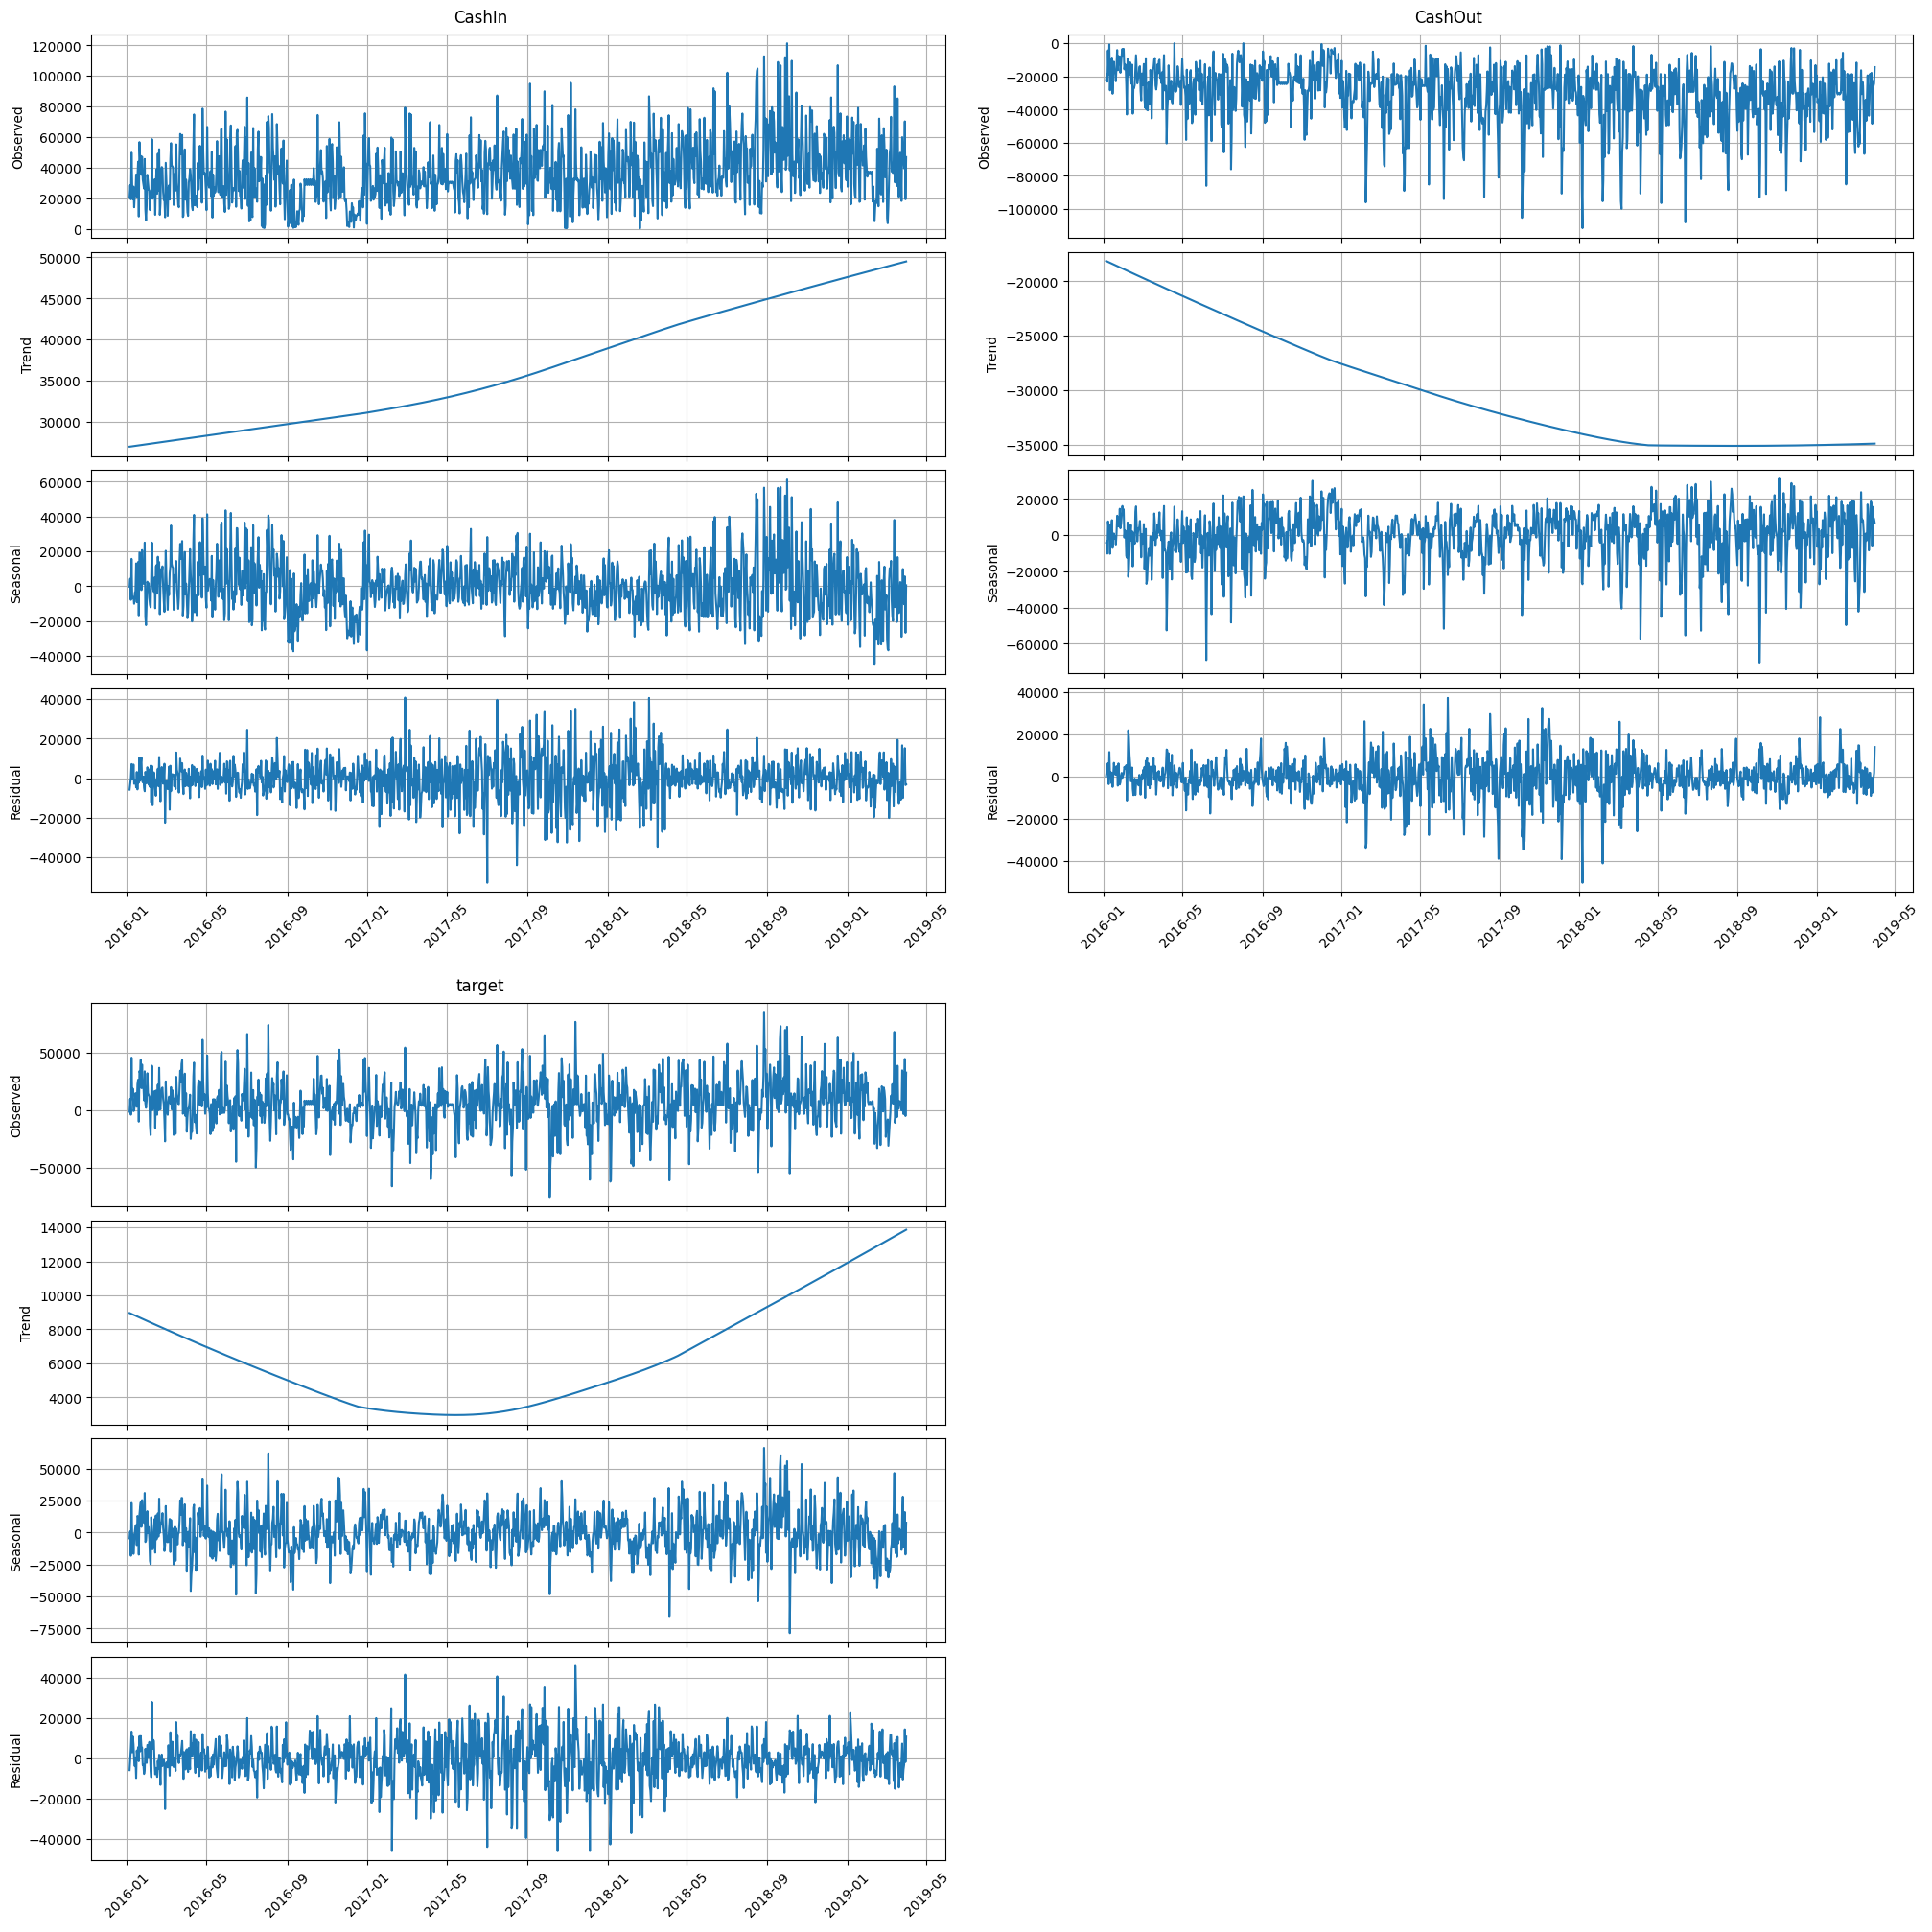

In [123]:
stl_plot(ts_fillna, period=365) # year

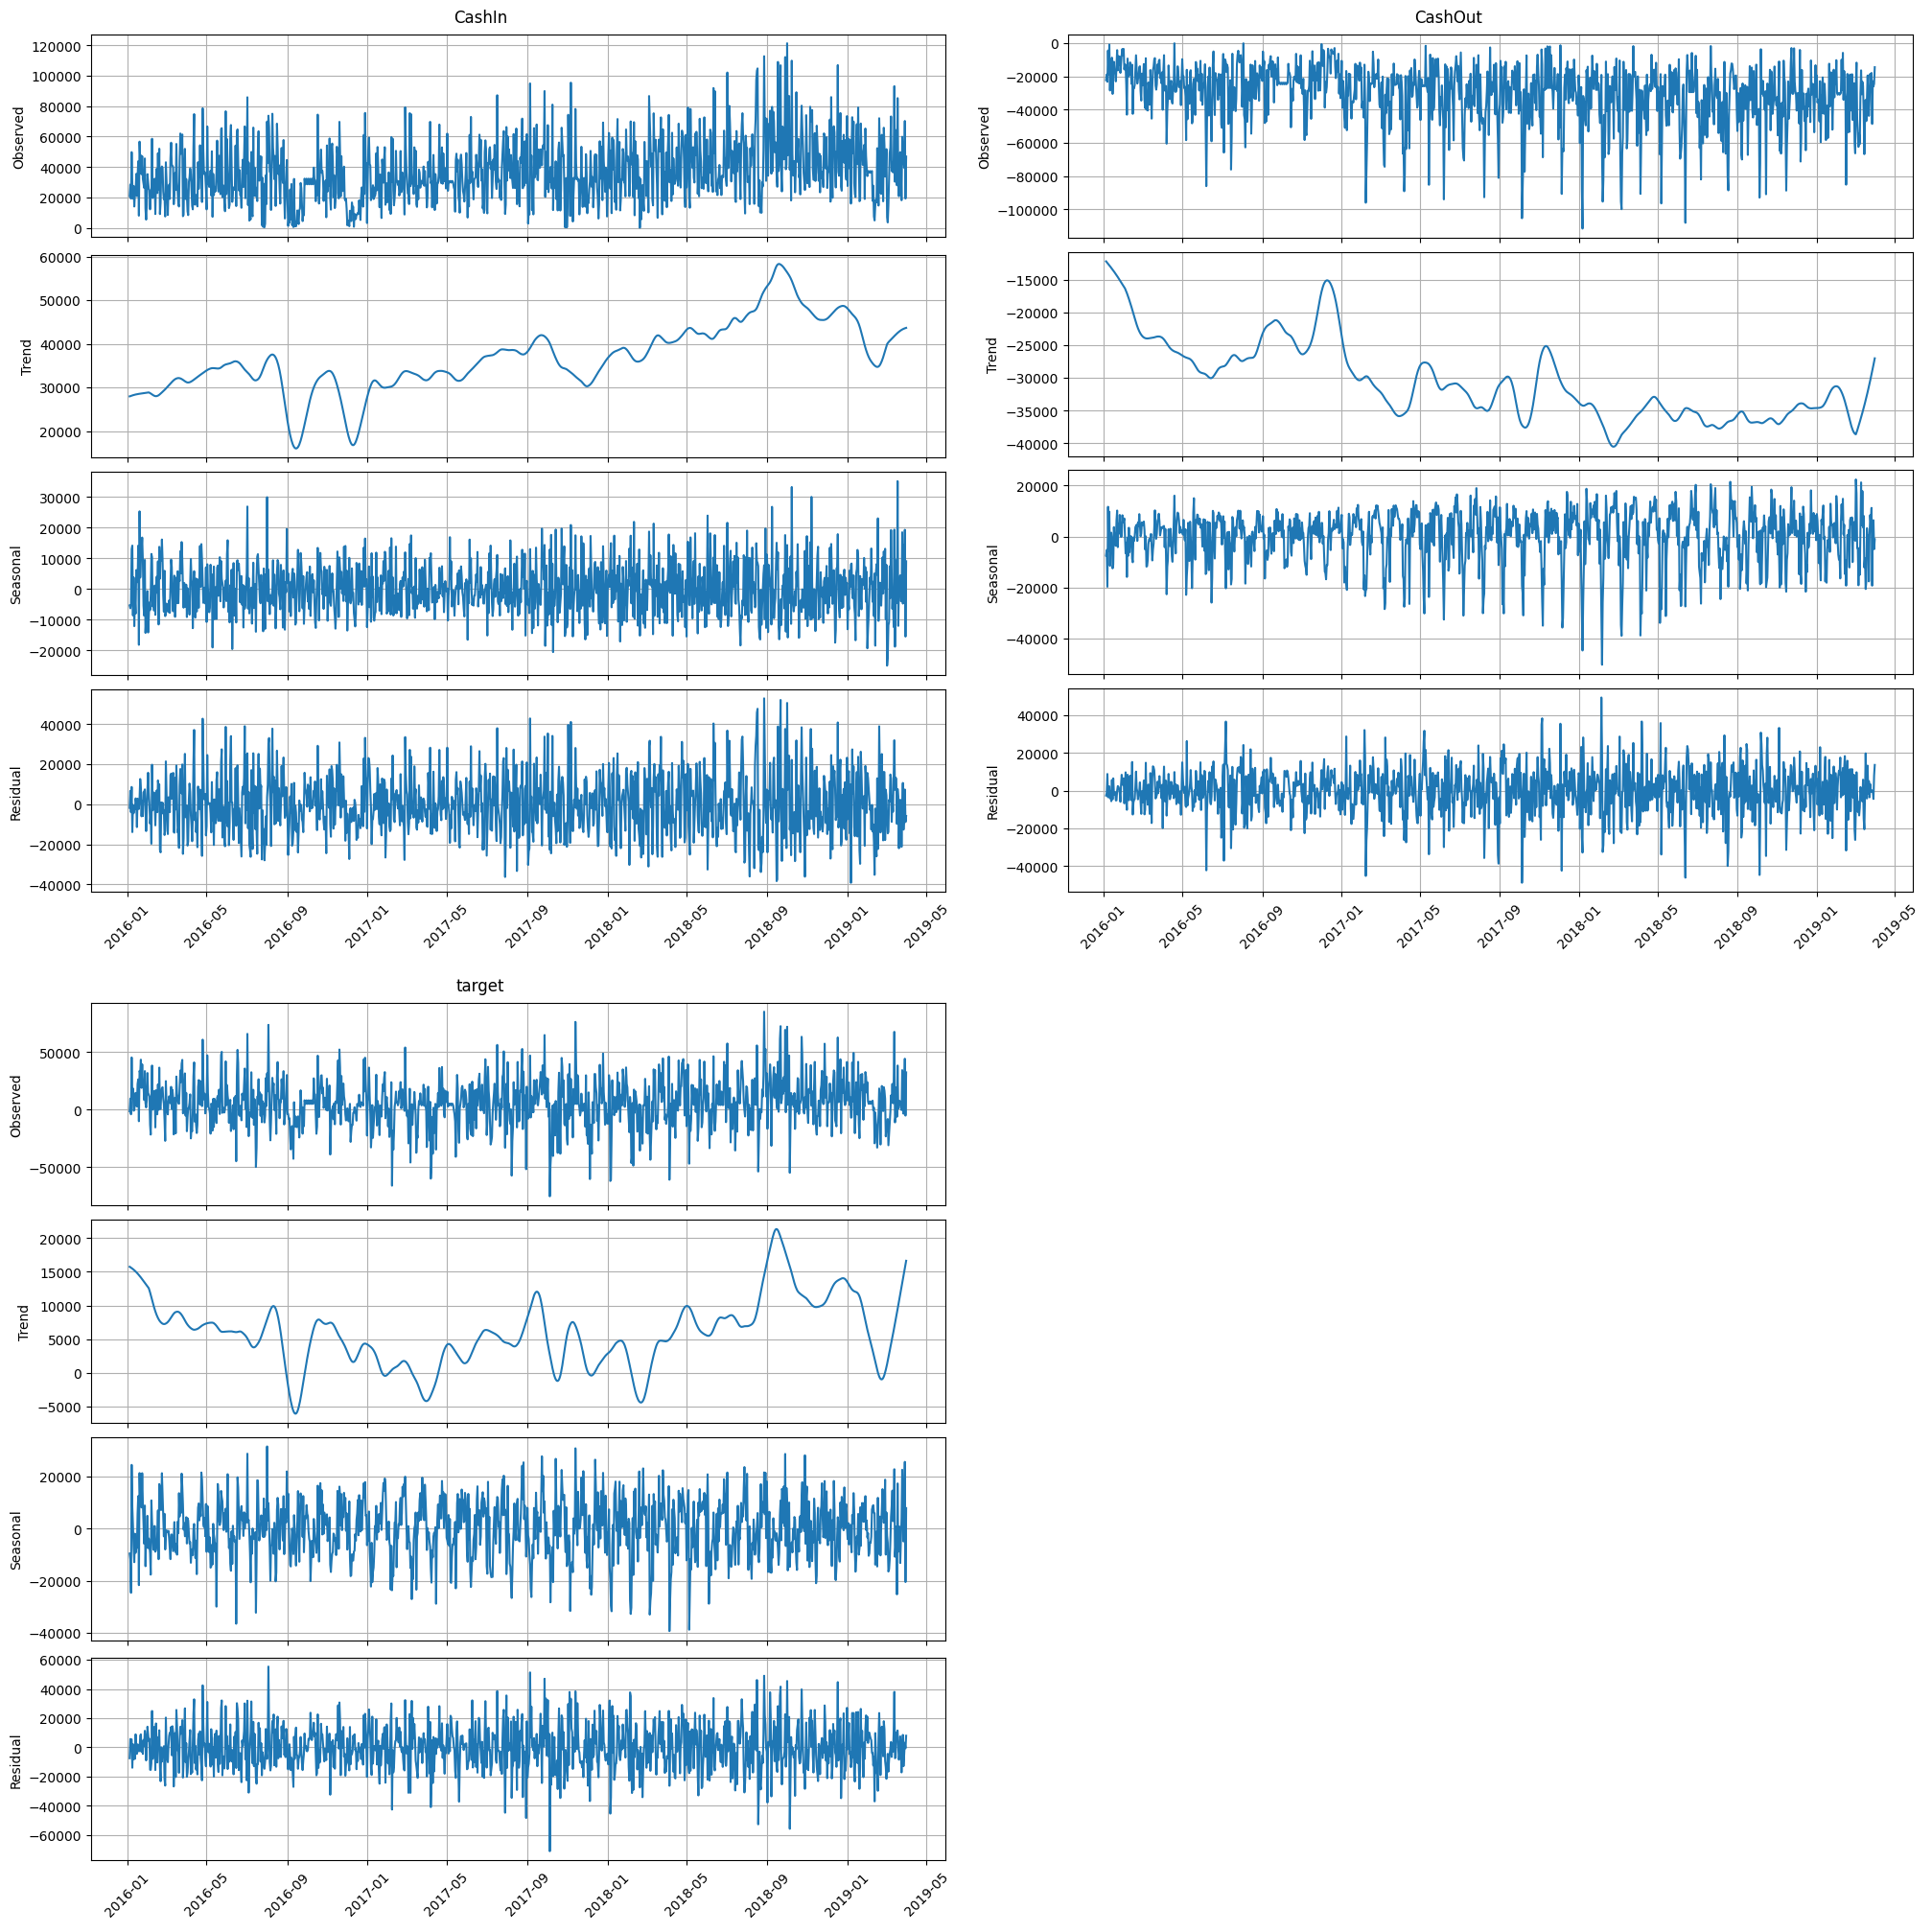

In [74]:
stl_plot(ts_fillna, period=30) # month

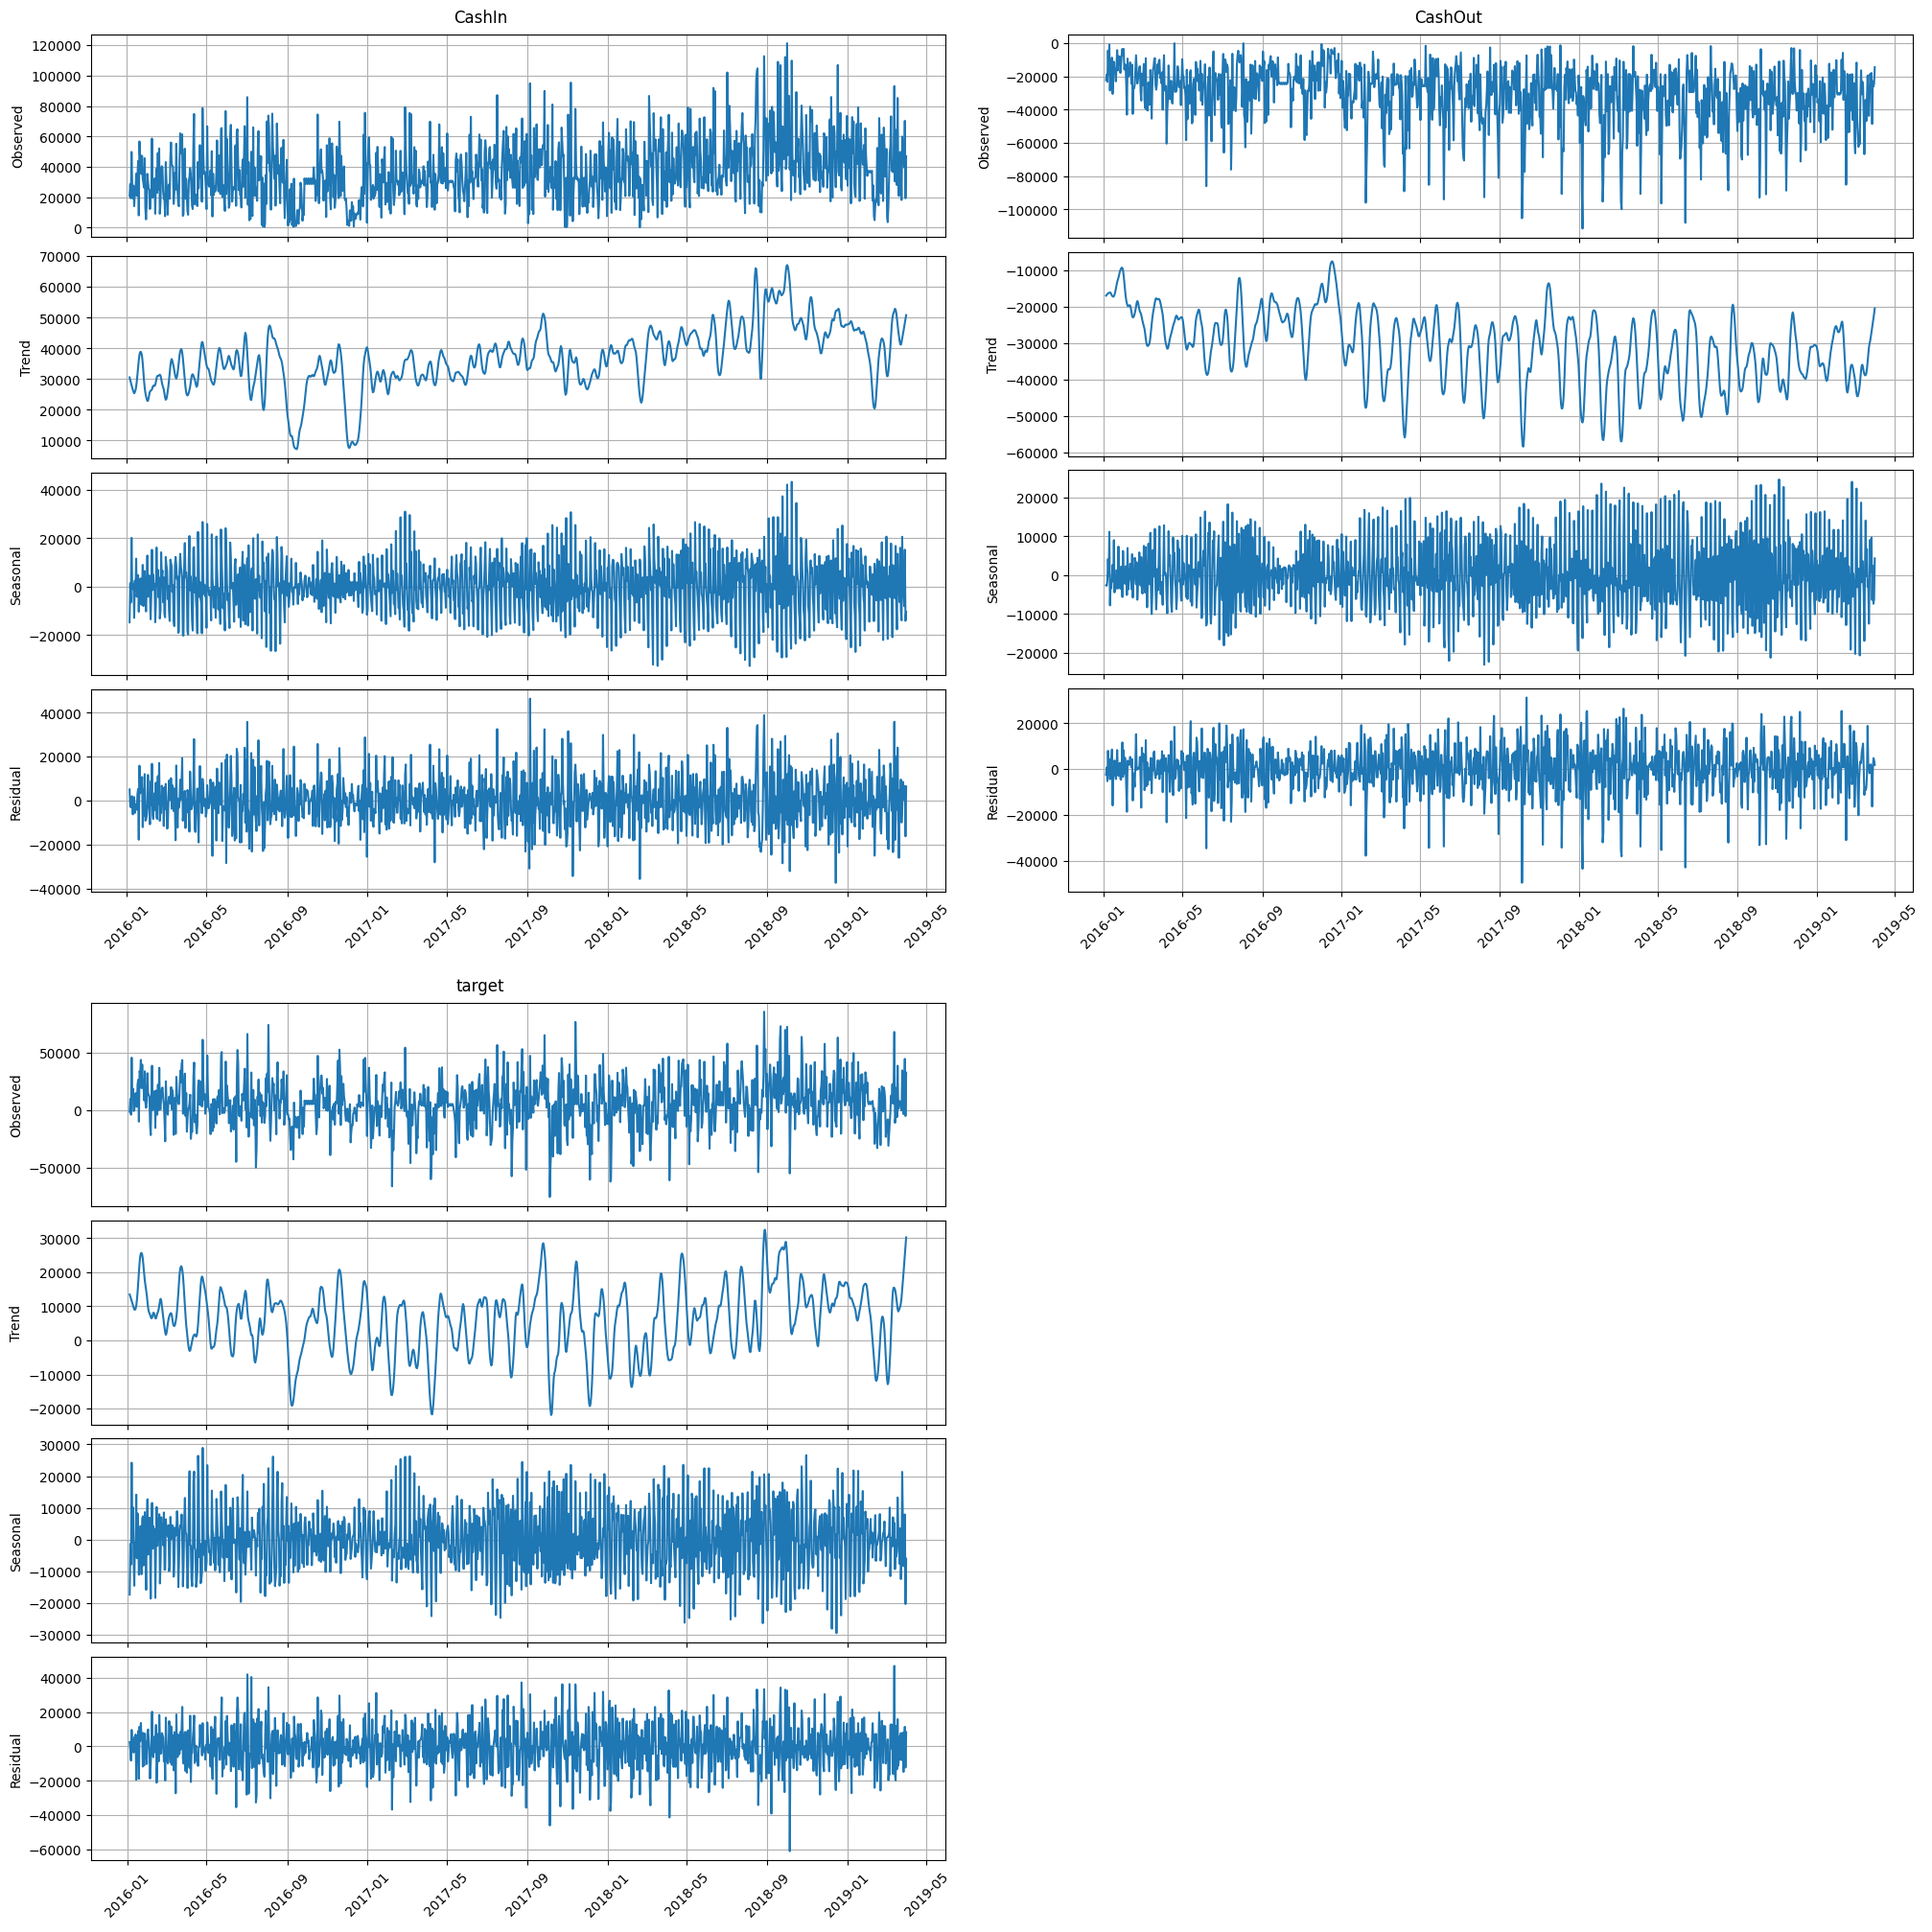

In [73]:
stl_plot(ts_fillna, period=7) # week

Думаю, что количество снятия наличности в банкомате может зависеть от таких параметров:
1. **месяц года**: кажется, что перед новым годом / учебным годом / летом люди тратят больше;
2. **день недели**: например, в сб и вс люди могут тратить больше, так как они не работают и могут пойти на какие-то развлечение;
3. к предыдущему пункту еще добавляются **официальные праздники** в стране, в которые люди будут тратить больше;
4. **год**: у нас маленький датасет, поэтому зависимось не вполне корректна, но, кажется, люди со временем все меньше снимают наличку, так как везде принимают карты;
5. **первые / последние недели месяца**, так как обычно именно в это время люди платят за связь, транспорт, подписки и аренду

In [127]:
from etna.transforms.timestamp.date_flags import DateFlagsTransform
from etna.transforms import HolidayTransform

lags = LagTransform(in_column='target', lags=list(range(29, 50, 1)), out_column='lag')
date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=True, 
                          week_number_in_month=True, week_number_in_year=True, 
                          month_number_in_year=True, year_number=True, is_weekend=True, out_column='date_flag')
holiday = HolidayTransform(out_column='holiday', iso_code='TUR')

transforms = [lags, date, holiday, SegmentEncoderTransform()]

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [85]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [ ]:
#YOUR CODE HERE#

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#